# Advanced Video Analytics

The tutorial shows some techniques for developing advanced video analytics applications.

### Setup the environment variables, download model files and import dependencies

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent.parent))
from demoTools.demoutils import *

In [ ]:
!/opt/intel/openvino/bin/setupvars.sh

In [ ]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name person-detection-retail-0013 -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name face-detection-adas-0001 -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name face-detection-adas-0001 -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name head-pose-estimation-adas-0001 -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name age-gender-recognition-retail-0013  -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name emotions-recognition-retail-0003  -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name facial-landmarks-35-adas-0002  -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name vehicle-license-plate-detection-barrier-0106 -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name vehicle-attributes-recognition-barrier-0039 -o models
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name license-plate-recognition-barrier-0001 -o models

In [ ]:
! python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_caffe.py --input_model models/public/mobilenet-ssd/mobilenet-ssd.caffemodel -o models/object_detection/common/mobilenet-ssd/FP32/ --scale 256 --mean_values [127,127,127]

## Part 1. Chaining models: Use mutiple models in an application

The Intel® Distribution of OpenVINO™ toolkit package includes security barrier sample which uses 3 models to detect cars, their number plates, color and number plate attributes from the input video or image of the cars. The sample demo script is provided in the Intel® Distribution of OpenVINO™ toolkit package to run the sample.

We will be using the below image in this example to detect multiple attributes from the input image.  

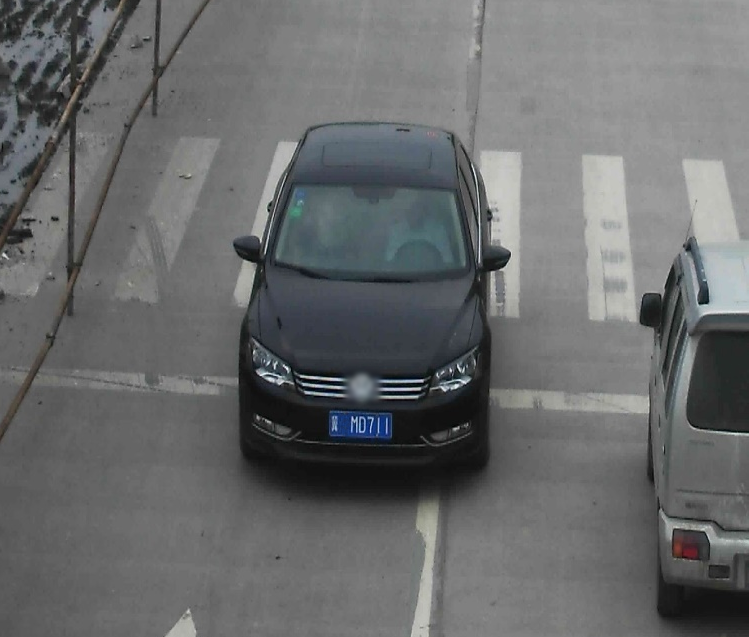

In [2]:
Image(filename='car_1.png')

### 3. Run the security camera sample with Intel optimized pre-trained models

Above script below run the security barrier camera example with Intel® pretrained models. In the script flags, you can see that the sample uses three pretrained models, vehicle-license-plate-detection-barrier, vehicle-attributes-recognition-barrier and license-plate-recognition-barrier to detect the car, it's make, color and license plate attributes. These pretrained models are optimized for particular tasks which yield better performance over generic object detection models. You can find more of such pretrained models under /opt/intel/openvino/deployment_tools/intel_models.

In [3]:
!./security_barrier_camera_demo -h

[ INFO ] InferenceEngine: 
	API version ............ 2.1
	Build .................. custom_releases/2019/R3_cb6cad9663aea3d282e0e8b3e0bf359df665d5d0
	Description ....... API

interactive_vehicle_detection [OPTION]
Options:

    -h                         Print a usage message.
    -i "<path1>" "<path2>"     Required for video or image files input. Path to video or image files.
    -m "<path>"                Required. Path to the Vehicle and License Plate Detection model .xml file.
    -m_va "<path>"             Optional. Path to the Vehicle Attributes model .xml file.
    -m_lpr "<path>"            Optional. Path to the License Plate Recognition model .xml file.
      -l "<absolute_path>"     Required for CPU custom layers. Absolute path to a shared library with the kernels implementation.
          Or
      -c "<absolute_path>"     Required for GPU custom kernels. Absolute path to an .xml file with the kernels description.
    -d "<device>"              Optional. Specify the target dev

In [4]:
%%writefile security_sample.sh
cd $PBS_O_WORKDIR
DEVICE=$1
./security_barrier_camera_demo -i car_1.png \
                                -m models/intel/vehicle-license-plate-detection-barrier-0106/FP32/vehicle-license-plate-detection-barrier-0106.xml \
                                -m_lpr models/intel/license-plate-recognition-barrier-0001/FP32/license-plate-recognition-barrier-0001.xml \
                                -d CPU

Overwriting security_sample.sh


In [ ]:
job_id_core = !qsub security_sample.sh -l nodes=1:tank-870:i5-6500te -F "CPU" -N obj_det_core
print(job_id_core[0])
while True:
    var=job_id_core[0].split(".")
    file="obj_det_core.o"+var[0]
    if os.path.isfile(file): 
        ! cat $file
        break

944.v-qsvr-1.devcloud-edge


In [ ]:
Image(filename='output.png')

## Part 2. Use multiple models on different hardware

### 0. Initialize the environmental variables

In [ ]:
!/opt/intel/openvino/bin/setupvars.sh

### 1. Let's look at the face detection sample from the Intel® Distribution of OpenVINO™ toolkit package

In [ ]:
!./interactive_face_detection_demo -h

### 2. Set path to the Input Video

In [ ]:
os.environ["VIDEO"] = "faces-recognition-walking-and-pause.mp4"

We will be using the below video in this example to detect multiple features from the input video.  

In [ ]:
videoHTML('Sample Video', 
          ['faces-recognition-walking-and-pause.mp4'])

### 3. Run the face demo, face detection only, on the Intel® Movidius™ Neural Compute stick


#### Create Job Script 

We will run the workload on several DevCloud's edge compute nodes. We will send work to the edge compute nodes by submitting jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

To pass the specific variables to the Python code, we will use following arguments:

* `-1`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Location of the output file 
* `-2`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Location of the input video

The job file will be executed directly on the edge compute node.

The input arguments are as follows:
* --name : name of the model you want to download. It should be one of the models listed in the previous cell
* -o : output directory. If this directory does not exist, it will be created for you.

There are more arguments to this script and you can get the full list using the `-h` option.


### Running the inference

Now we are ready to run the inference workload. In this step we will be submitting the workload as a job to the job queue.

Currently, you are on what is called a "devnode". On this system, you are allocated just one core on a large Intel® Xeon® CPU. The purpose of this node is to develop code on the devnode and run minimal sections of Jupyter* Notebooks, but it is not meant for compute intensive jobs like deep learning inference. So we need to request additional resources from the cluster of Edge nodes to run the inference, and this is done through the job queue.

To put an item on the job queue, we must first create a bash script that run the workload we want. Run the following cell to create bash script infer_face.sh which will be our job script. 

In [ ]:
%%writefile infer_face.sh
#PBS
INPUT_FILE=$1
DEVICE=$2
OUTPUT_FILE=$3

cd $PBS_O_WORKDIR
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/
    
./interactive_face_detection_demo -i $INPUT_FILE -no_wait \
-m models/intel/face-detection-adas-0001/FP16/face-detection-adas-0001.xml \
-d $DEVICE \
-o $OUTPUT_FILE

In [ ]:
#Submit job to the queue
job_id_ncs2 = !qsub infer_face.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "$VIDEO MYRIAD results/ncs2_face/"
print(job_id_ncs2[0])

#Progress indicators
if job_id_ncs2:
    progressIndicator('results/ncs2_face', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

In [ ]:
videoHTML('Face Detection [MYRIAD]',
          ['results/ncs2_face/output.mp4'])

### 4. Now we add (to the face detection) also an age and gender detection, running on the CPU

In [ ]:
%%writefile infer_ag.sh
#PBS
INPUT_FILE=$1
DEVICE=$2
OUTPUT_FILE=$3

cd $PBS_O_WORKDIR
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/
    
./interactive_face_detection_demo -i $INPUT_FILE -no_wait \
-m models/intel/face-detection-adas-0001/FP16/face-detection-adas-0001.xml \
-m_ag models/intel/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml \
-d $DEVICE -d_ag CPU \
-o $OUTPUT_FILE

In [ ]:
#Submit job to the queue
job_id_ncs2 = !qsub infer_ag.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "$VIDEO MYRIAD results/ncs2_ag/"
print(job_id_ncs2[0])

#Progress indicators
if job_id_ncs2:
    progressIndicator('results/ncs2_ag', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

In [ ]:
videoHTML('Face Detection [MYRIAD], Age/Gender [GPU]',
          ['results/ncs2_ag/output.mp4'])

### 5. Now we’ll add an head position detection, running on the GPU

In [ ]:
%%writefile infer_hp.sh
#PBS
INPUT_FILE=$1
DEVICE=$2
OUTPUT_FILE=$3

cd $PBS_O_WORKDIR
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/
    
./interactive_face_detection_demo -i $INPUT_FILE -no_wait \
-m models/intel/face-detection-adas-0001/FP16/face-detection-adas-0001.xml \
-m_ag models/intel/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml \
-m_hp models/intel/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml \
-d $DEVICE -d_ag CPU -d_hp GPU \
-o $OUTPUT_FILE

In [ ]:
#Submit job to the queue
job_id_ncs2 = !qsub infer_hp.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "$VIDEO MYRIAD results/ncs2_hp/"
print(job_id_ncs2[0])

#Progress indicators
if job_id_ncs2:
    progressIndicator('results/ncs2_hp', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

In [ ]:
videoHTML('Face Detection[MYRIAD] | Age/Gender[CPU] | Head Pose [GPU] :',
          ['results/ncs2_hp/output.mp4'])

### 6. Now we’ll add an emotion detector, running on the GPU

In [ ]:
%%writefile infer_ed.sh
#PBS
INPUT_FILE=$1
DEVICE=$2
OUTPUT_FILE=$3

cd $PBS_O_WORKDIR
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/
    
./interactive_face_detection_demo -i $INPUT_FILE -no_wait \
-m models/intel/face-detection-adas-0001/FP16/face-detection-adas-0001.xml \
-m_ag models/intel/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml \
-m_hp models/intel/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001.xml \
-m_em models/intel/emotions-recognition-retail-0003/FP16/emotions-recognition-retail-0003.xml \
-d $DEVICE -d_ag CPU -d_hp GPU -d_em GPU \
-o $OUTPUT_FILE

In [ ]:
#Submit job to the queue
job_id_ncs2 = !qsub infer_ed.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "$VIDEO MYRIAD results/ncs2_ed/"
print(job_id_ncs2[0])

#Progress indicators
if job_id_ncs2:
    progressIndicator('results/ncs2_ed', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

In [ ]:
videoHTML('Face Detection[MYRIAD] | Age/Gender[CPU] | Head Pose, Emotion [GPU]:',
          ['results/ncs2_ed/output.mp4'])